**Installs**

Since the dataset is a parquet file, we use pyarrow

WARNING: THE DATASET CONTAINS TEXT THAT MIGHT BE CONSIDERED VULGAR, PROFANE OR OFFENSIVE

In [1]:
!pip install pyarrow
!pip install transformers
!pip install imbalanced-learn

**Imports**

In [2]:
import pyarrow.parquet as pq
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import re
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
from transformers import AdamW
from collections import defaultdict
import tqdm.notebook as tq
import numpy as np
import os

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

**Filtering Labels**

In [4]:
df = pq.read_table(source='/kaggle/input/parquet-train/train-00000-of-00001-b7e9c6cc40ccf6d2.parquet').to_pandas()
df['encoded_labels'] = df['encoded_labels'].apply(lambda x: x[:4]) #considering the first 4 labels using an anonymous function
df.head()

,text,labels,encoded_labels
0,Go ahead and merge what you think is necessary...,[],"[0, 0, 0, 0]"
1,"""\n\n Merging Red Hand of Doom and Reliability...",[],"[0, 0, 0, 0]"
2,You never responded to this: any luck? —,[],"[0, 0, 0, 0]"
3,"\fuck you, who the shit is ari?","[toxic, profane, insult]","[1, 1, 1, 0]"
4,"This is a school computer, so any edits which ...",[],"[0, 0, 0, 0]"


In [5]:
df.tail()

,text,labels,encoded_labels
710492,@terajolayugular but and this being of light d...,[hate],"[0, 0, 0, 1]"
710493,#happiness of the constitution I believe that ...,[hate],"[0, 0, 0, 1]"
710494,The shame that accompanies us to the world.I w...,[hate],"[0, 0, 0, 1]"
710495,"He shoots him 16 times and yells at him ""Don't...",[hate],"[0, 0, 0, 1]"
710496,"Neither left nor right, but I defend the neo-N...",[hate],"[0, 0, 0, 1]"


In [6]:
df.shape

(710497, 3)

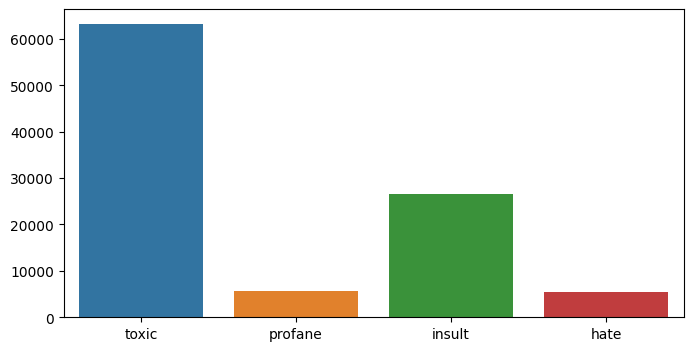

,text,labels,encoded_labels,toxic,profane,insult,hate
0,Go ahead and merge what you think is necessary...,[],"[0, 0, 0, 0]",0,0,0,0
1,"""\n\n Merging Red Hand of Doom and Reliability...",[],"[0, 0, 0, 0]",0,0,0,0
2,You never responded to this: any luck? —,[],"[0, 0, 0, 0]",0,0,0,0
3,"\fuck you, who the shit is ari?","[toxic, profane, insult]","[1, 1, 1, 0]",1,1,1,0
4,"This is a school computer, so any edits which ...",[],"[0, 0, 0, 0]",0,0,0,0


In [7]:
labels = ["toxic", "profane", "insult", "hate"]
for row, label in enumerate(labels):
    df[label] = df["encoded_labels"].apply(lambda x: x[row])
df.head()
occ = df[labels].sum()
plt.figure(figsize=(8,4))
sns.barplot(x=occ.index,y=occ.values)
plt.show()
df.head()

**Downsampling and Upweighting of majority class "toxic"**

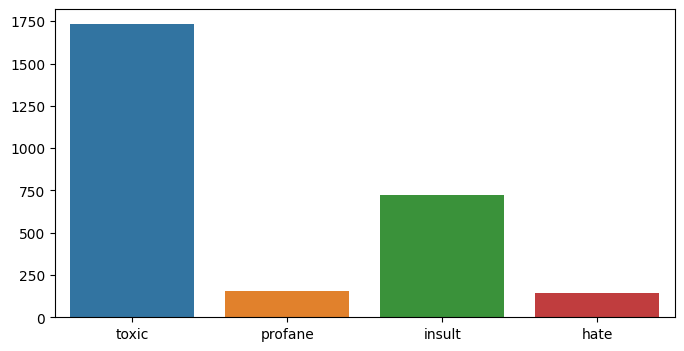

,text,labels,encoded_labels,toxic,profane,insult,hate
512855,Je suppose que Trump aurait pu agir comme Obam...,[],"[0, 0, 0, 0]",0,0,0,0
536323,Avoir une emprise. Ce n'est pas du tout ce que...,[],"[0, 0, 0, 0]",0,0,0,0
557933,"En ne revendiquant Mandela que pour eux-mêmes,...",[],"[0, 0, 0, 0]",0,0,0,0
619211,Est-ce que quelqu'un se demande combien de foi...,[],"[0, 0, 0, 0]",0,0,0,0
518208,Le parti travailliste a esquivé cette balle.,[],"[0, 0, 0, 0]",0,0,0,0


In [8]:
#downsampling a bit
sample_length = 20000  # Adjust this value to your desired sample size
df = df.sample(n=sample_length, random_state=42)

occ = df[labels].sum()
plt.figure(figsize=(8,4))
sns.barplot(x=occ.index,y=occ.values)
plt.show()
df.head()

Text Cleaning

In [9]:
def clean(txt):
    txt = txt.lower()
    txt = re.sub(r"[!\"#\$%&\'\(\)\*\+,-\./:;<=>\?@\[\\\]\^_`{\|}~]" , "" , txt)
    txt = txt.strip()
    return txt
df['text'] = df['text'].apply(clean)

In [10]:
tok = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
target = list(df.columns)
target = target[3:]
target

['toxic', 'profane', 'insult', 'hate']

In [12]:
#train test validation split
df_train, df_val = train_test_split(df, random_state=42, test_size = 0.3, shuffle=True)
print(df_train.shape)
print(df_val.shape)
df_train.head()

(14000, 7)
(6000, 7)


,text,labels,encoded_labels,toxic,profane,insult,hate
171924,i think its more about powers and less about p...,[],"[0, 0, 0, 0]",0,0,0,0
150414,probably correct its likely the least profita...,[toxic],"[1, 0, 0, 0]",1,0,0,0
639164,hundreds of immigrant children are still separ...,[],"[0, 0, 0, 0]",0,0,0,0
526960,la plupart des pays ont des bases de données h...,[],"[0, 0, 0, 0]",0,0,0,0
708474,experiencia covid lejos hermano consiguió covi...,[],"[0, 0, 0, 0]",0,0,0,0


**PyTorch Dataset**

In [13]:
class PTDataset(torch.utils.data.Dataset):
    def __init__(self, df, targets, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['text'])
        self.max_len = max_len
        self.targets = self.df[target].values
        
    def __len__(self):
        return len(self.title)
    
    def __getitem__(self,index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens = True,
            max_length = self.max_len,
            padding = 'max_length',
            return_token_type_ids = True,
            truncation = True,
            return_attention_mask = True,
            return_tensors = 'pt'
        )
        
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }

MAKING THE CUSTOM DATASETS

In [14]:
#hyperparameters
MAX_LEN = 256
#method calling
dataset_train = PTDataset(df_train, target, tok, MAX_LEN) 
dataset_val = PTDataset(df_val, target, tok, MAX_LEN) 
print(dataset_train[30])

{'input_ids': tensor([  101, 28681,  2891,  3690, 15530,  8183,  8159,  2229,  1041,  1999,
        10288,  4842, 13122,  1037,  2474,  2310,  2480, 28681,  2891, 16839,
        19610,  2891,  4078,  4842, 17713,  2080,  4372, 11503,  3022,  2139,
         5869, 10861, 17504, 15530, 18609,  4895,  4097,  2080, 25540,  8180,
         9365,  4078, 14289,  2229,  2139, 14477,  2053,  5403,  2139,  2022,
         5677, 19461,  3022,  3449,  2273,  3736,  6460,  2139,  5677,  2401,
        14262, 19817,  3686,  2139,  2053, 14262, 17183, 15396,  3527,  2175,
        14277, 13775,  2080, 20801,  2015,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

DATA LOADERS

In [15]:
train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size = 16,
    shuffle = True,
    num_workers = 4
)

val_loader = torch.utils.data.DataLoader(
    dataset_val,
    batch_size = 16,
    shuffle = True,
    num_workers = 4
)

BUILDING THE MODEL WITH BERT 

In [16]:
class BERT(torch.nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 4)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERT()
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERT(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [17]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5)         

In [18]:

# Training of the model for one epoch
def train_model(train_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(train_loader), total=len(train_loader), 
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,8)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()

        # Update progress bar
        #loop.set_description(f"")
        #loop.set_postfix(batch_loss=loss)

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

def eval_model(val_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size   # total number of elements in the 2D array

    return float(correct_predictions)/num_samples, np.mean(losses)
     

In [19]:
import numpy as np
EPOCHS=10
torch.cuda.empty_cache()
history = defaultdict(list)
best_accuracy = 0
data_dir = '/kaggle/working/'
for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), os.path.join(data_dir,"model_state.bin"))
        best_accuracy = val_acc

Epoch 1/10


  0%|          | 0/875 [00:00<?, ?it/s]

train_loss=0.1384, val_loss=0.0940 train_acc=0.9638, val_acc=0.9742
Epoch 2/10


  0%|          | 0/875 [00:00<?, ?it/s]

train_loss=0.0887, val_loss=0.0939 train_acc=0.9763, val_acc=0.9730
Epoch 3/10


  0%|          | 0/875 [00:00<?, ?it/s]

train_loss=0.0706, val_loss=0.0972 train_acc=0.9813, val_acc=0.9724
Epoch 4/10


  0%|          | 0/875 [00:00<?, ?it/s]

train_loss=0.0583, val_loss=0.1157 train_acc=0.9843, val_acc=0.9743
Epoch 5/10


  0%|          | 0/875 [00:00<?, ?it/s]

train_loss=0.0451, val_loss=0.1129 train_acc=0.9878, val_acc=0.9738
Epoch 6/10


  0%|          | 0/875 [00:00<?, ?it/s]

train_loss=0.0340, val_loss=0.1203 train_acc=0.9899, val_acc=0.9694
Epoch 7/10


  0%|          | 0/875 [00:00<?, ?it/s]

train_loss=0.0235, val_loss=0.1303 train_acc=0.9929, val_acc=0.9701
Epoch 8/10


  0%|          | 0/875 [00:00<?, ?it/s]

train_loss=0.0185, val_loss=0.1373 train_acc=0.9943, val_acc=0.9719
Epoch 9/10


  0%|          | 0/875 [00:00<?, ?it/s]

train_loss=0.0134, val_loss=0.1453 train_acc=0.9959, val_acc=0.9721
Epoch 10/10


  0%|          | 0/875 [00:00<?, ?it/s]

train_loss=0.0111, val_loss=0.1579 train_acc=0.9964, val_acc=0.9702


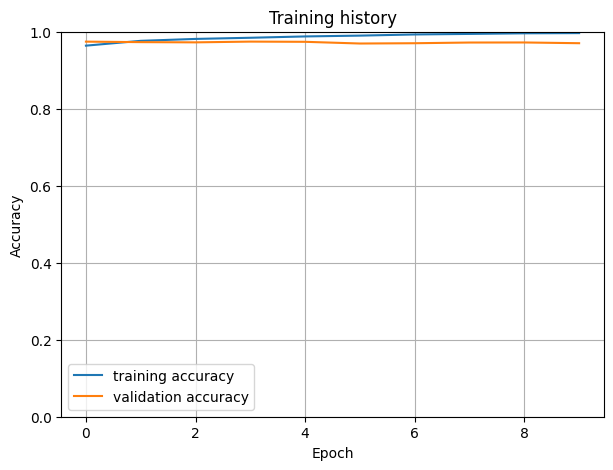

In [20]:
#visualisation of training process
plt.rcParams["figure.figsize"] = (7,5)
plt.plot(history['train_acc'], label='training accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()